In [1]:
from pylab import *
import random_idx
from __future__ import division
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


height has been deprecated.

2016-07-26 11:12


In [2]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [3]:
def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

def p_corr_rej(M, N=10000, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N * reject_thresh, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [6]:
def cconv(a, b):
    return real(ifft(fft(a) * fft(b)))
    
def ccinv(a):
    return real(ifft(np.conj(fft(a))))

## Plate's Probability Derivations and Comparison

Plate follows a similar strategy of deriving the capacity bounds, but considers a different question. Our analysis diverges after the first step of using Central Limit Theorm to describe hit and reject distributions. Plate's analysis leads to $s_a$ ($a$ for *accept distribution*) and $s_r$ (as in *reject distribution*).

Exactly as our derivation, Plate arrives at 

$$
s_a := \mathscr{N}\left(1, \frac{k+1}{n}\right)
$$
$$
s_r := \mathscr{N}\left(0, \frac{k}{n}\right)
$$

but then Plate's analysis diverges. Plate takes the first step of defining $t$ (which he uses twice, unfortunately, but this is our threshold term), which acts as the threshold and the memory item will be recognized if the dot product exeeds this threshold. Then he defines the term Pr(All Correct):

$$
\begin{split}
Pr(All Correct) &= Pr(Hit)^k Pr(Reject)^{m-k} \\
& = max_t Pr(s_a > t)^k Pr(s_r < t) ^{m-k}
\end{split}
$$

So this is indeed quite a different question than what our analysis considers. Lets translate into code and see how it works. In our terminology: $N=n, M=k, D=m, \theta=t$.

Essential to note is that given the way Plate defined the problem -- a subset of $k$ ($M$) unique elements out of $m$ ($D$) possibilities -- that $k$ ($M$) must be less than $m$ ($D$). Since we used trajectory association, we do not have this issue. 



In [26]:
def p_plate(M, N=10000, D=27, thresh=0.5, ares=2000):
    psa = 1 - ncdf((thresh-1)/((M+1)/N)**0.5)
    psr = ncdf(thresh/((M/N)**0.5))
    
    return psa**M * psr ** (D - M)


First, lets compare Plate's theory to the theory that we derived. The key difference between our results is that Plate found Pr(All Correct), while we found Pr(Correct). However, since the letter decodings are independing, these should be related by simply raising Pr(Correct) to the $M$th power:

$$
Pr(All Correct) = p_{corr}^M
$$
Another issue is that Plate says that there is an ideal threshold for a given set of parameters. I am not going to worry about this ideal threshold and just keep a fixed threshold of 0.5. We can thus compare the results of the two theories.

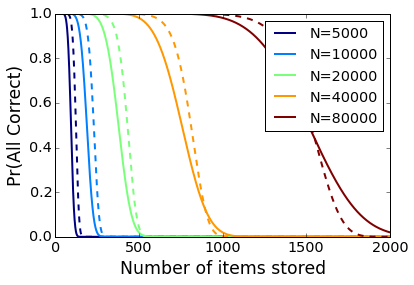

In [45]:
M = arange(2000)+1
D = 5000
test_N = [5000, 10000, 20000, 40000, 80000]

cm = get_cmap('jet', len(test_N))

for iN,N in enumerate(test_N):
    plot(M, p_plate(M, N=N, D=D), lw=2, c=cm(iN), label="N=%i" % N)
    plot(M, p_hit(M, N=N, D=D)**M, '--', lw=2, c=cm(iN))
    
legend(loc='upper right')
xlabel('Number of items stored')
ylabel('Pr(All Correct)')


**Figure 1: Comparison with Plate theory.** Plate derived Pr(All Correct) and this is plotted in solid lines for different values of N with D fixed at 5000. In dashed lines is the new capacity theory raised to the $M$th power to reflect the probability of decoding all letters correctly.



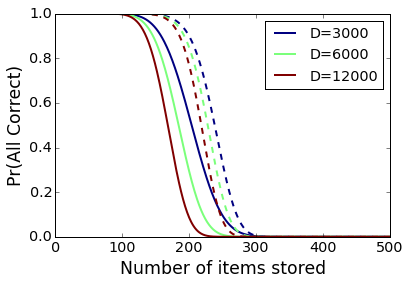

In [44]:
M = arange(500)+1
test_D = [3000, 6000, 12000]

cm = get_cmap('jet', len(test_D))

for iD,D in enumerate(test_D):
    plot(M, p_plate(M, D=D), lw=2, c=cm(iD), label="D=%i" % D)
    plot(M, p_hit(M, D=D)**M, '--', lw=2, c=cm(iD))
    
legend(loc='upper right')
xlabel('Number of items stored')
ylabel('Pr(All Correct)')


**Figure 2: Comparison with Plate's theory.** Plate's derivation is plotted in solid lines with different values of $D$ and fixed $N$. The new capacity theory is shown in dashed lines.

### Plate's lower bound

Plate also derives in the thesis a lower bound to the capacity equation. He uses an approximation of the error function in a similar fashion to ours. He cites Abramowitz and Stegun (1965) saying:

$$
erfc(x) < \frac{2}{\sqrt{\pi}} e^{-x^2} \frac{1}{x+\sqrt{x^2+4/\pi}}
$$

$$
erfc(x) < \frac{1}{x\sqrt{\pi}}e^{-x^2}
$$

He then uses this relationship to find $q = 1 - Pr(All Correct)$:

$$
\begin{split}
q &= \frac{m}{2} erfc \left( \frac{1}{2} \sqrt{ \frac{n}{2(k+1)} } \right) \\
&< m e^{\frac{-n}{8 (k+1)}}
\end{split}
$$ 

conditional on $\sqrt{ \frac{2(k+1)}{\pi n} } < 1$. (this step isn't exactly clear to me).

And then rearranging:

$$
n < 8(k+1) ln (\frac{m}{q} )
$$

$$
k > \frac{n}{8ln(m/q)} - 1
$$

Translated to our terminology:

$$
N < 8 M [ \log (D-1) - \log (1-p_{all}) ]
$$

This is actually quite close to our derivation in many respects. Let's first review our bound on $p_{corr}$. We use a similar bound stating that:

$$
\Phi(x) > 1 - \frac{1}{2} e ^{ \frac{-x^2}{2} }
$$

which then leads to:

$$
p_{corr} > \left[ 1 - \frac{1}{2} e ^ {\frac{-N}{4M}} \right]^{D-1} \approx e ^ {\frac{D-1}{2} e ^ {-\frac{N}{4M} } }
$$

(I also think that this can be derived using the ideas of the Extreme Value Distribution, and it may be a simpler derivation/argument)

We then solve this equation and take $\epsilon := \log(2(1-p_{corr}))$:

$$
N = 4 M ( \log(D-1) - \epsilon )
$$



In [113]:
h = np.load('data/p_correct-theory-N=12-D=16-n160503.npz')
p_correct = h['p_correct']
test_N = h['test_N']
test_D = h['test_D']

p_tol=1.00000: N = M * ( 4.02 log2(D) + 116.99 )
p_tol=1.00000: N = M * ( 3.91 log2(D) + 81.02 )
p_tol=1.00000: N = M * ( 3.87 log2(D) + 54.02 )
p_tol=0.99999: N = M * ( 3.71 log2(D) + 36.64 )
p_tol=0.99900: N = M * ( 3.40 log2(D) + 19.52 )
p_tol=0.90000: N = M * ( 2.58 log2(D) + 3.31 )
p_tol=0.80000: N = M * ( 2.31 log2(D) + 1.12 )
p_tol=0.70000: N = M * ( 2.09 log2(D) + 0.02 )


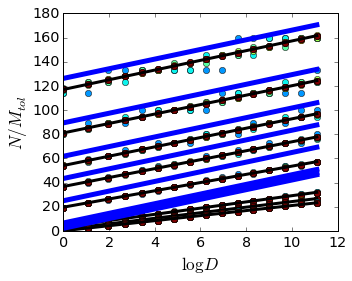

In [114]:
import scipy
from scipy import stats

test_p_tol = [1-1e-14, 1-1e-10, 1-1e-7, 1-1e-5, 1-1e-3, 1-1e-1, 1-2e-1, 1-3e-1]

figure(figsize=(5,4))

cm = get_cmap('jet', len(test_N))

stN=3
p_tol_M = np.zeros((len(test_N), len(test_D), len(test_p_tol)))
slD = np.nan*np.zeros((len(test_N), len(test_p_tol)))
intD = np.nan*np.zeros((len(test_N), len(test_p_tol)))

for ip, p_tol in enumerate(test_p_tol[0:]):
    #for iN,N in enumerate(test_N):
    for iN in range(stN, len(test_N)):
        N = test_N[iN]
        for iD,D in enumerate(test_D):
            m_idx = np.nonzero(np.squeeze(p_correct[iN, iD, :]) < p_tol)[0]
            if len(m_idx) < 1:
                p_tol_M[iN, iD, ip] = N
            else:
                p_tol_M[iN, iD, ip] = m_idx[0]
            
        xD = np.log(np.array(test_D)-1)
        yD = N / p_tol_M[iN, :, ip]
        slD[iN, ip], intD[iN, ip], r, p, err = stats.linregress(xD, yD)
        
        plot(xD, yD, 'o', color=cm(iN), label="N=%2d" % N)
        #plot(xD, slD[iN, ip] * xD + intD[iN, ip], color=cm(iN))
       
    plot(xD, np.nanmean(slD[:,ip]) *xD + np.nanmean(intD[:,ip]), 'k', lw=3)

    
    thD = np.array(test_D)
    eps_tol = 1 - p_tol
    yTheory =  4 * (np.log(thD-1) - np.log(2*eps_tol))
    #yTheory =  - 4 * np.log(sqrt(2*eps_tol/(thD-1)+0.25) -0.5)   
                    
    plot(np.log(thD-1), yTheory, 'b', lw=5)

    print "p_tol=%.5f: N = M * ( %2.2f log2(D) + %2.2f )" % (p_tol, np.nanmean(slD[:,ip]), np.nanmean(intD[:,ip]))

xlabel('$\log D$')
ylabel('$N/M_{tol}$')

plt.tight_layout()

savefig('figures/linear_NMtol_fit-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMtol_fit-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure 3: Analytic versus empirical bounds on capacity.** The $p_{corr}$ equation was solved many times and the largest value $M_{tol}$ was found such that $p_{corr} > p_{tol}$ for a given set of parameters. Notably, a precise linear relationship is found for large enough N that tightly links N, M, and D (circles, hotter circles indicate larger N), and the black line indicates a linear fit of the empirically determined values. We use the bound to find an analytic approximation of this linear relationship, shown as blue lines.

So, we can see that our theory does a pretty good job given that is a lower bound (an hence over-estimates the $N$ needed for storing $M_{tol}$ items). The slope of the theoretical lines is also quite close to the slope of the empirical lines for $p_{tol}$ near 1.

Next, we are going to attempt the same type of analysis, but we have to translate to Plate's scenario. Basically, instead of find $M_{tol}$ where the probability of decoding an individual letter of the $M$ letters stored is less than $p_{tol}$, we are going to find $M_{all}$ where the probability of decoding all $M$ letters is less than $p_{all}$. 

We can easily compare this with the new version of the capacity theory by again raising $p_{corr}$ to the $M$th power. 

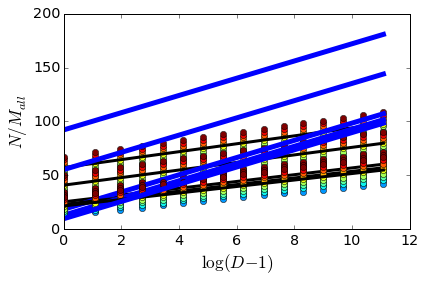

In [117]:
import scipy
from scipy import stats

test_p_all = [1-1e-5, 1-1e-3, 1-1e-1, 1-2e-1, 1-3e-1]

stN=3
pall_tol_M = np.zeros((len(test_N), len(test_D), len(test_p_tol)))
slD = np.nan*np.zeros((len(test_N), len(test_p_tol)))
intD = np.nan*np.zeros((len(test_N), len(test_p_tol)))

cm = get_cmap('jet', len(test_N))
for ip, p_tol in enumerate(test_p_all[0:]):
    #for iN,N in enumerate(test_N):
    for iN in range(stN, len(test_N)):
        N = test_N[iN]
        M = arange(p_correct.shape[2])+1
        for iD,D in enumerate(test_D):
            m_idx = np.nonzero(np.squeeze(p_correct[iN, iD, :]**M) < p_tol)[0]
            if len(m_idx) < 1:
                pall_tol_M[iN, iD, ip] = N
            else:
                pall_tol_M[iN, iD, ip] = m_idx[0]
            
        xD = np.log(np.array(test_D)-1)
        yD = N / pall_tol_M[iN, :, ip]
        slD[iN, ip], intD[iN, ip], r, p, err = stats.linregress(xD, yD)
        
        plot(xD, yD, 'o', color=cm(iN), label="N=%2d" % N)
    plot(xD, np.nanmean(slD[:,ip]) *xD + np.nanmean(intD[:,ip]), 'k', lw=3)

    thD = np.array(test_D)
    eps_tol = 1 - p_tol
    yTheory =  8 * (np.log(thD-1) - np.log(eps_tol))
    #yTheory =  - 4 * np.log(sqrt(2*eps_tol/(thD-1)+0.25) -0.5)   
                    
    plot(np.log(thD-1), yTheory, 'b', lw=5)
xlabel('$\log (D-1)$')
ylabel('$N/M_{all}$')

plt.tight_layout()


**Figure 4: Relationships based on Pr(All Correct).** The theory was adjusted to Pr(All Correct) by raising $p_{corr}$ to the $M$th power and the largest value $M_{all}$ was found such that $p_{corr} ^ M < p_{all}$. This was found for different tolerances ($p_{all}$) and values for $D$, $N$ and plotted as circles. Black lines show linear fits for a given tolerance level. Blue lines show Plate's lower bound.

Of most importance to note about these lines is that the circles are not directly on top of each other like they are in the previous figure. This means that there isn't an exact linear relationship that relates $\log (D-1)$ with $N/M_{all}$ like there is that relates $\log (D-1)$ with $N/M_{tol}$. You can see the general fact that $N/M_{all}$ is smaller when $N$ is smaller. This is not that surprising, and is just a consequence of finding $Pr(All Correct)$ instead of finding $p_{corr}$. However, the relationhsip is *linear-ish*. 

The Blue lines are then Plate's lower bound theory. These are pretty off, and the slope isn't great. 

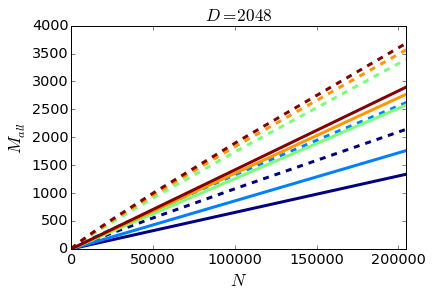

In [126]:
iD = 10
cm = get_cmap('jet', len(test_p_all[0:]))
for ip, p_tol in enumerate(test_p_all[0:]):
    #for iN,N in enumerate(test_N):
    #for iD, D in enumerate(test_D):
    plot(test_N, pall_tol_M[:, iD, ip], '--', c=cm(ip), lw=3, label="$p_{tol}=1-10^{%0.1f}$" % np.log10(1-p_tol))
    
    plate_kb = test_N / (8 * np.log(test_D[iD]/(1-p_tol))) - 1
    plate_ka = test_N / (3.16 * np.log(test_D[iD]/(1-p_tol)**3)) +0.25
    
    plot(test_N, plate_kb, c=cm(ip), lw=3)
    #plot(test_N, plate_ka, c=cm(ip), lw=3)
    
xlim([0, max(test_N)])
ylim([0, 4000])

xlabel('$N$')
ylabel('$M_{all}$')
title("$D=%i$" % test_D[iD])

#legend(loc='upper left')

**Figure 5: Linear relationship between $N$ and $M_{all}$.** The linear relationship between $N$ and $M_{all}$ remains, but the approximation Plate derived (solid lines) is quite different from the new capacity theory (dashed lines). 

## Why the disagreement?

Plate's states that $Pr(All Correct) = Pr(s_a > \theta) ^ M Pr(s_r < \theta) ^ {D - M}$, but this is not exactly right, and is the reason that we have disagreement. 

Based on our theoretical results, we state that:
$$
Pr(All Correct) = p_{corr} ^ M = \left[ \int_\theta^\infty Pr(s_a = h) \left( Pr(s_r < h) \right)^{D-1} dh \right]^M
$$

Plate's probability statement isn't correct because it does not consider all scenarios: e.g. there is a chance that both $s_a$ and one of the $s_r$ values is greater than $\theta$, and the letter can still be classified correctly because we take the maximum as the correct choice. The impact of this scenario and other such scenarios is missing from Plate's theory.